In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
import mediapy
from rich.pretty import pprint
from tqdm.auto import tqdm

from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

,

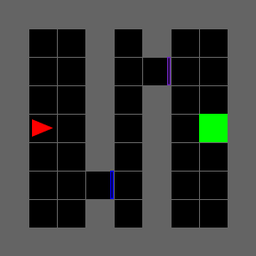
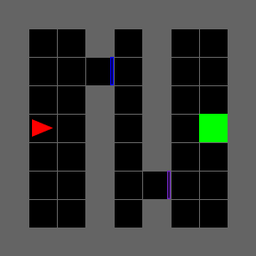

In [2]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in [0, 1]:
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=200)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

In [3]:
from envs.minigrid.env_utils import random_exploration, q_learning

train_layout_data = []
NUM_TRAIN_LAYOUTS = 2
NUM_TRAIN_STEPS = 200
NUM_TRAIN_EPISODES = 300

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    # dataset, env = q_learning(env, NUM_TRAIN_EPISODES, layout_type=i)
    dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i)
    train_layout_data.append(dataset)
    
# ds, env = random_exploration(env)
# env.visualize_coverage()

  0%|          | 0/2 [00:00<?, ?it/s]

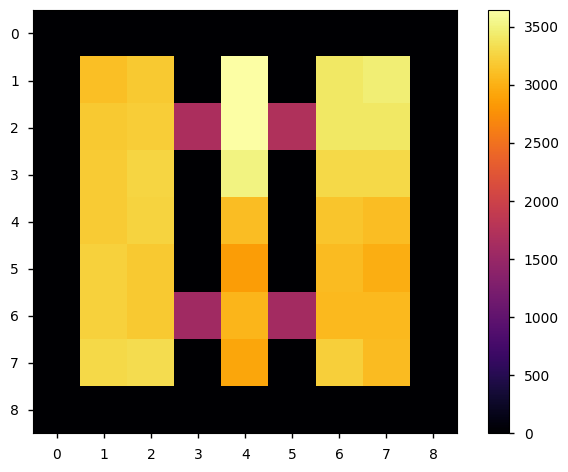

In [5]:
# TRAIN DATA COVERAGE
coverage_map = np.zeros(shape=(env.env.unwrapped.width, env.env.unwrapped.height))
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

In [5]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    iql_config = compose(config_name='entry.yaml', overrides=['experiment=gciql_dynamics.yaml']) # gciql gciql_dynamics
    iql_config = OmegaConf.to_container(iql_config, resolve=True)
    pprint(iql_config)
    
def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# np.save(f"../aux_data/iql_door_data_meta", arr=jax.device_get(whole_data))
# whole_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/iql_door_data_meta.npy", allow_pickle=True).item()
# whole_data = dataset_random
print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=iql_config['agent'])

# batch, batch_context, batch_context2 = gc_whole_dataset.sample(1, layout_type=1, context_length=20)

{
│   'seed': 42,
│   'run_group': 'gciql',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 5000,
│   'eval_interval': 5000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'gciql',
│   │   'discrete': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.2,
│   │   'value_p_trajgoal': 0.8,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 1.0,
│   │   'actor_p_randomgoal': 0.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'lr': 0.0003,
│   │   'batch_size': 256,
│   │   'const_std': True,
│   │   'actor_hidden_dims': [512, 512, 512],
│   │   'value_hidden_dims': [512, 512, 512],
│   │   'layer_norm': True,
│   │   'actor_loss': 'awr',
│   │   'alpha': 0.003,
│   │   'use_film': False,
│   │   'use_context': True,
│   │   'warmup_steps': 50000,
│   │   'n_blocks': 3,
│   │   'n_heads': 4,
│   │   'h_dim': 8,
│   │   'context_len': 128,
│   │   'number_of_meta_envs': 2,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'expectile': 0.9
│   },
│   'env': {'env_name': 'doors_context', 'discrete': True},
│   'tags': ['dynamics_gciql', 'discrete']
}

{'actions': (119400,), 'layout_type': (119400,), 'next_observations': (119400, 2), 'observations': (119400, 2), 'terminals': (119400,)}


In [6]:
example_batch = gc_whole_dataset.sample(1)
# pprint(jax.tree.map(lambda x: x.shape, example_batch))
iql_agent = GCIQLAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.env.action_space.n - 1),
    config=iql_config['agent']
)
batch, batch_context, batch_context2 = gc_whole_dataset.sample(1, layout_type=0, context_length=20)
pprint(jax.tree.map(lambda x: x.shape, batch_context))

{
│   'actions': (1, 20, 1),
│   'layout_type': (1, 20, 1),
│   'next_observations': (1, 20, 2),
│   'observations': (1, 20, 2),
│   'terminals': (1, 20, 1)
}

{'actions': (127,), 'layout_type': (127,), 'next_observations': (127, 2), 'observations': (127, 2), 'terminals': (127,)}
(24,)


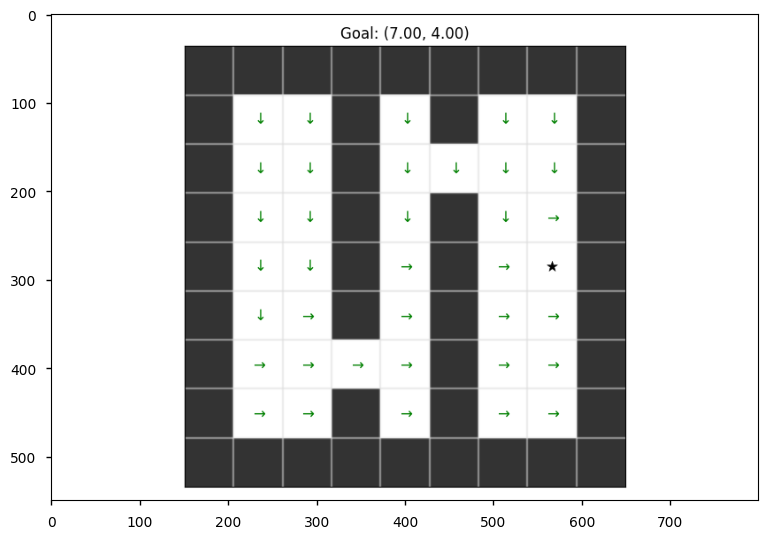

In [7]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

def visualize_policy_image(layout_type):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=iql_config['agent']['context_len'] if iql_config['agent']['use_context'] else None)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    if iql_config['agent']['use_context']:
        dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=layout_type)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                    dataset_inference['next_observations'][None],
                                                                                     jnp.tile(goal[None, None], reps=(1, iql_config['agent']['context_len'] - 1, 1)), train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding.squeeze()
    print(dynamics_embedding.shape)
    example_batch = whole_dataset.sample(1)
    pred_policy_img = policy_image_grid(env, example_batch,
                                                    action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                    goals=goal, dynamics_embedding=dynamics_embedding, temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

pred_policy_img = visualize_policy_image(layout_type=0)
plt.imshow(pred_policy_img)
plt.tight_layout()

{'actions': (127,), 'layout_type': (127,), 'next_observations': (127, 2), 'observations': (127, 2), 'terminals': (127,)}


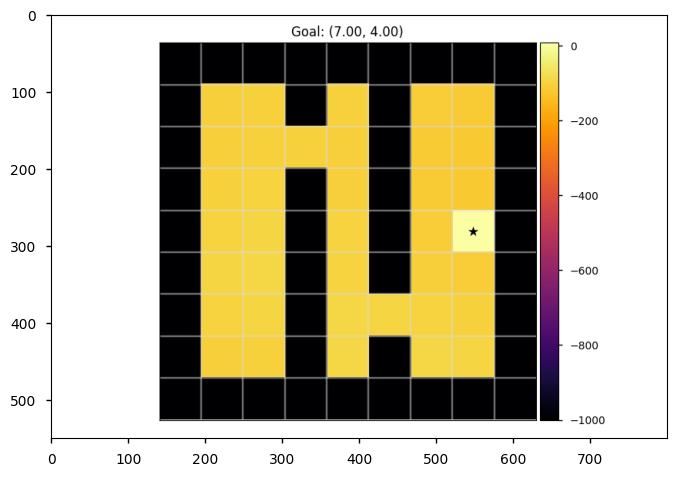

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def value_fn(agent, obs, goal, action, dynamics_embedding=None):
    q1, q2 = agent.network.select('critic')(obs, goal, action, dynamics_embedding=dynamics_embedding)
    q = jnp.minimum(q1, q2)
    return q / 0.02

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    # print(grid)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1), goal, action))
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

def visualize_value_image(layout_type):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=iql_config['agent']['context_len'] if iql_config['agent']['use_context'] else None)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    if iql_config['agent']['use_context']:
        dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=layout_type)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                    dataset_inference['next_observations'][None], jnp.tile(goal[None, None], reps=(1, iql_config['agent']['context_len'] - 1, 1)), train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding.squeeze()

    pred_value_img = value_image_fourrooms(env, example_batch,
                                value_fn=partial(value_fn, iql_agent, dynamics_embedding=dynamics_embedding), action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                    goals=goal, temperature=0.0, dynamics_embedding=dynamics_embedding), goal=goal)
    return pred_value_img

pred_value_img = visualize_value_image(1)
plt.imshow(pred_value_img)


{'actions': (127,), 'layout_type': (127,), 'next_observations': (127, 2), 'observations': (127, 2), 'terminals': (127,)}
(24,)
{'actions': (127,), 'layout_type': (127,), 'next_observations': (127, 2), 'observations': (127, 2), 'terminals': (127,)}
{'actions': (127,), 'layout_type': (127,), 'next_observations': (127, 2), 'observations': (127, 2), 'terminals': (127,)}
(24,)
{'actions': (127,), 'layout_type': (127,), 'next_observations': (127, 2), 'observations': (127, 2), 'terminals': (127,)}


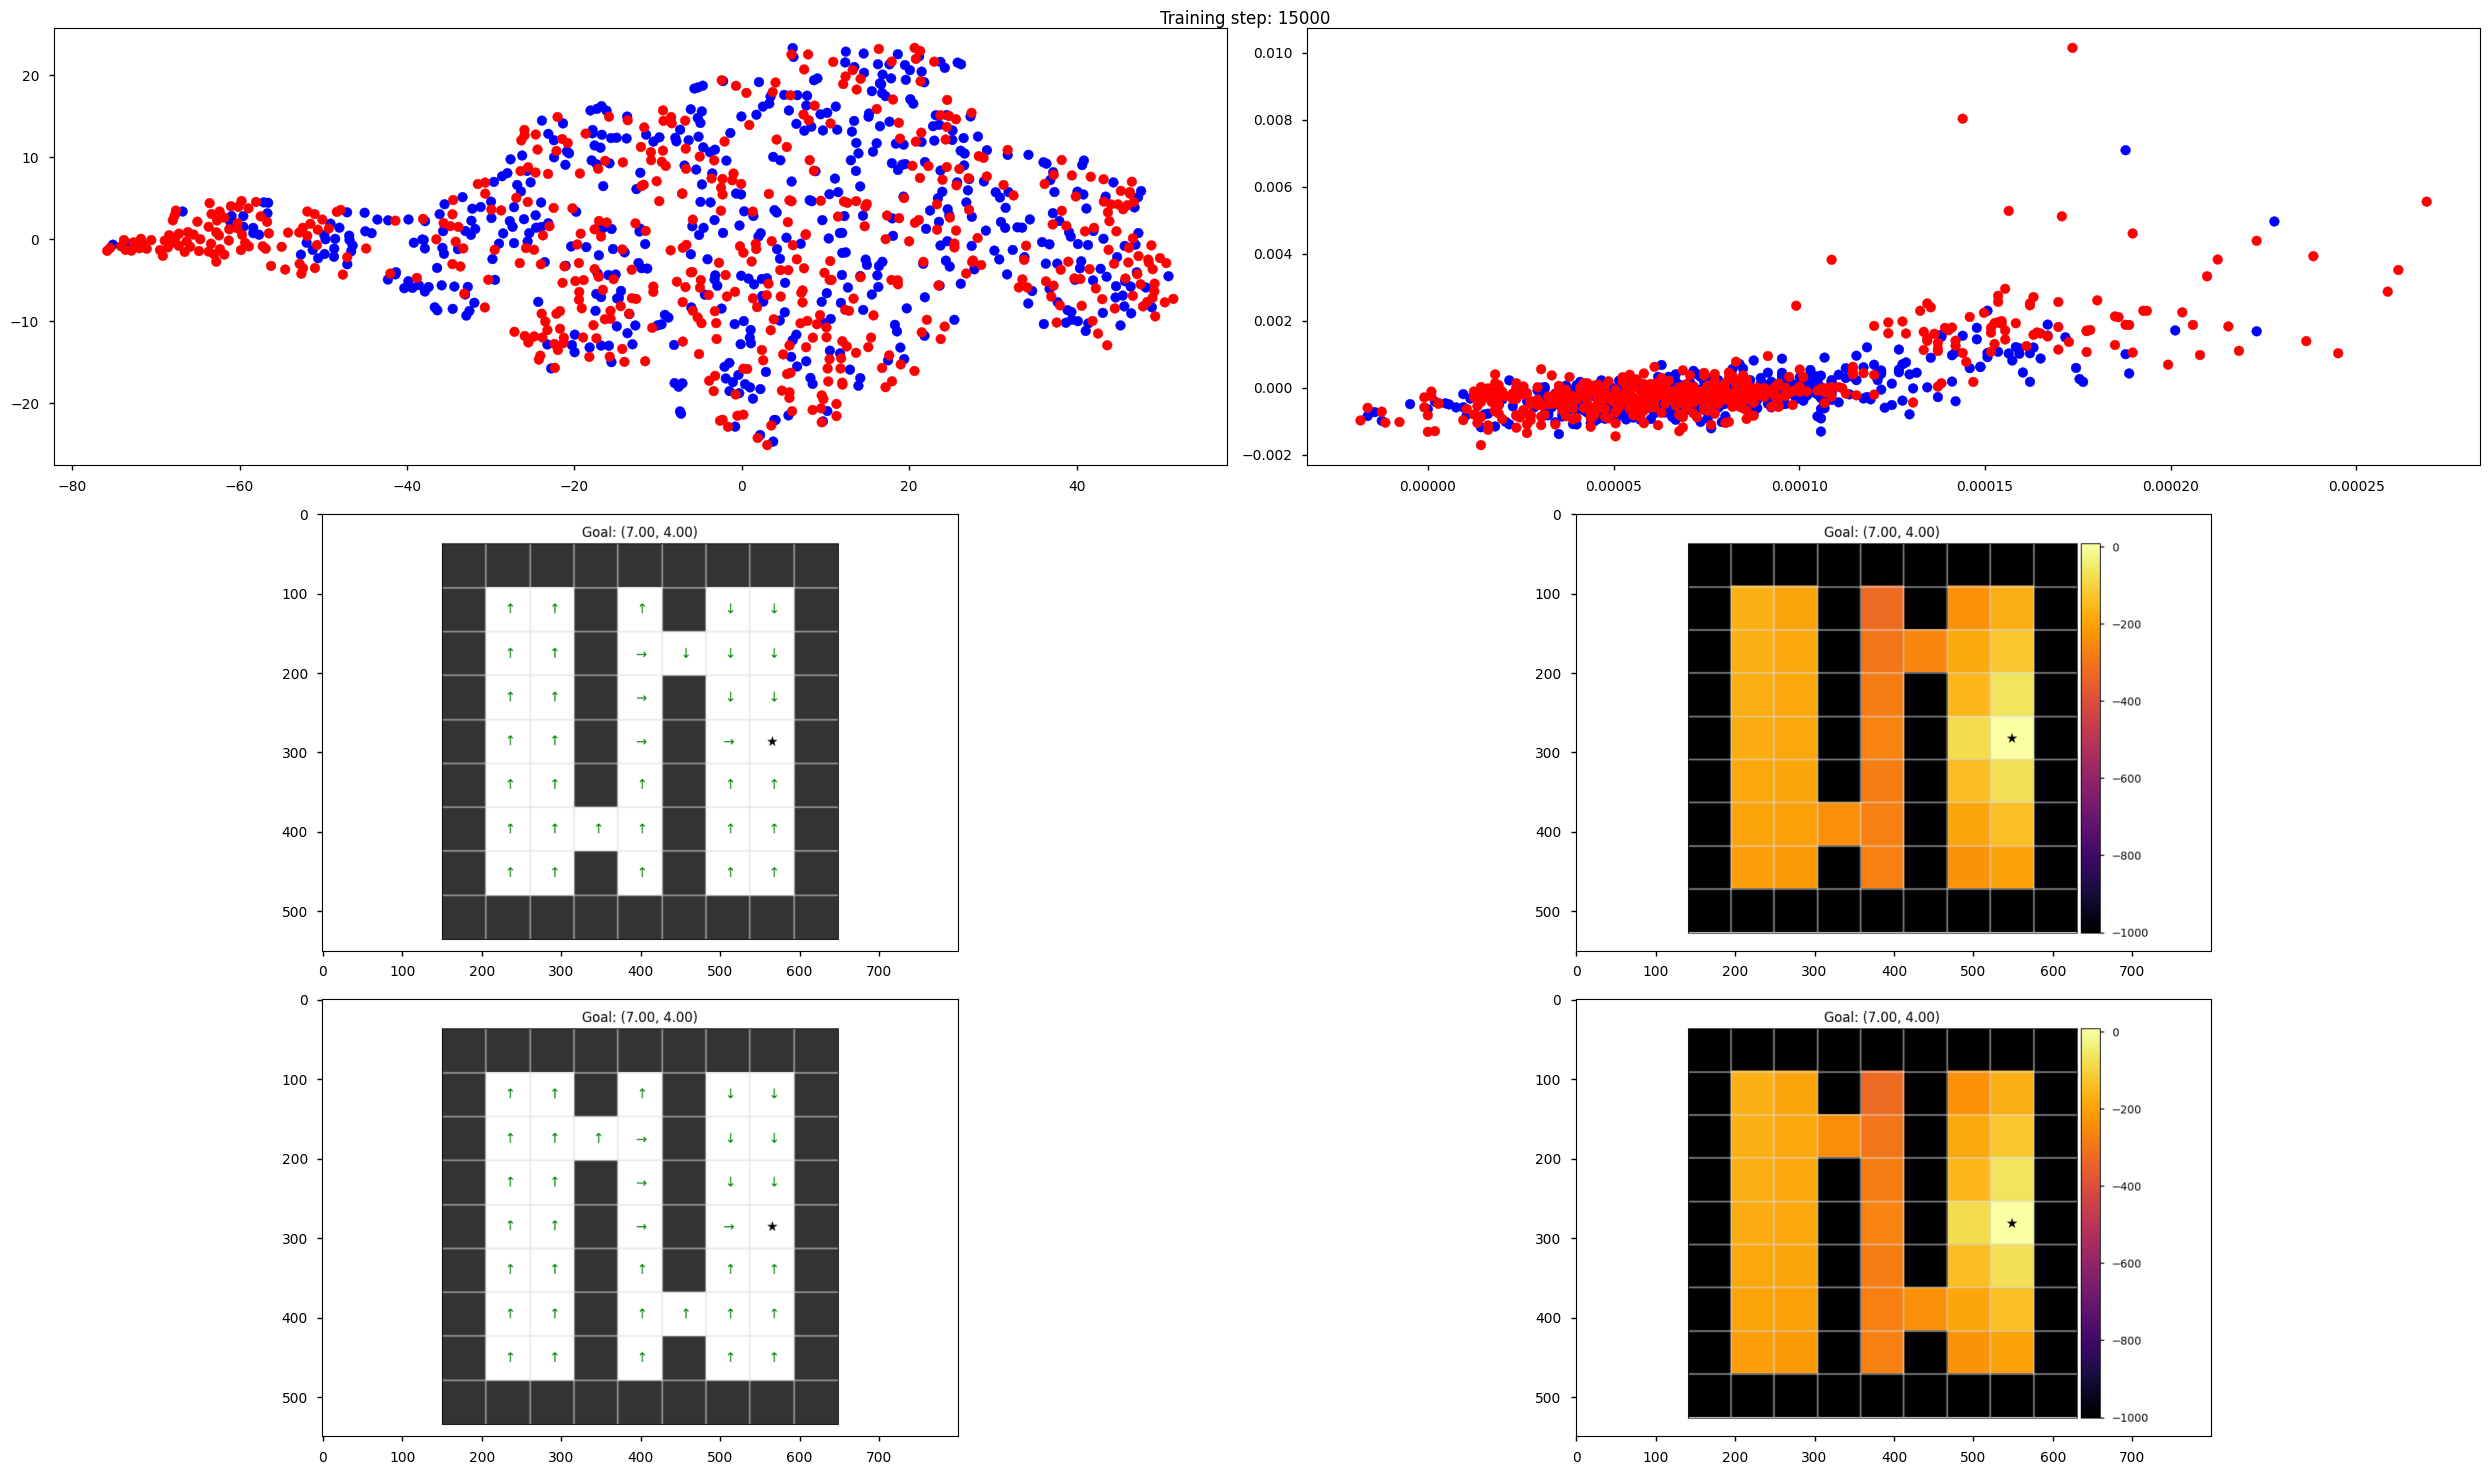

KeyboardInterrupt: 

In [9]:
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap

def pos_to_state(pos):
    return int(pos[0] * 9 + pos[1])

pbar = tqdm(range(200_000))
layout_embs = []

cmap = LinearSegmentedColormap.from_list('recent_to_old', ['cyan', 'black'])
obs, info = env.reset()
goal = info.get("goal_pos")
# with jax.disable_jit():
if iql_config['agent']['use_context']:
    _, batch_context_test0, _ = gc_whole_dataset.sample(512, layout_type=0,
                                                                            context_length=iql_config['agent']['context_len'])
    _, batch_context_test1, _ = gc_whole_dataset.sample(512, layout_type=1,
                                                                            context_length=iql_config['agent']['context_len'])
    # # _, batch_context_test2, _ = gc_whole_dataset.sample(512, layout_type=2,
    # #                                                                         context_length=iql_config['agent']['context_len'])
    colors = ['blue'] * batch_context_test0['observations'].shape[0] + ['red'] * batch_context_test1['observations'].shape[0]
    test_embedding = jax.tree.map(lambda x, y: jnp.concatenate([x, y]), batch_context_test0, batch_context_test1)
goal = jnp.tile(jnp.array(goal)[None, None], reps=jnp.array([test_embedding['observations'].shape[0], test_embedding['observations'].shape[1], 1]))

for update_steps in pbar:
    if not iql_config['agent']['use_context']:
        batch = gc_whole_dataset.sample(iql_config['agent']['batch_size'])
        iql_agent, update_info = iql_agent.update(batch, train_context_embedding=False)
    else:
        batch, batch_context, _ = gc_whole_dataset.sample(iql_config['agent']['batch_size'], layout_type=update_steps % NUM_TRAIN_LAYOUTS,
                                                            context_length=iql_config['agent']['context_len'])
        _, negative_context, _ = gc_whole_dataset.sample(iql_config['agent']['batch_size'], layout_type=(update_steps + 1) % NUM_TRAIN_LAYOUTS,
                                                            context_length=iql_config['agent']['context_len'])
        iql_agent, update_info = iql_agent.update(batch, batch_context, train_context_embedding=update_steps % 2 == 0 and update_steps < 10_000, negative_context=negative_context)
        
    # if update_steps % 1_000 == 0 and iql_config['agent']['use_context']:
    #     for layout_type in range(0, NUM_TRAIN_LAYOUTS):
    #         _, batch_context, _ = gc_whole_dataset.sample(1, layout_type=layout_type,
    #                                                             context_length=iql_config['agent']['context_len'])
    #         dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(batch_context['observations'], batch_context['actions'],
    #                                                                                 batch_context['next_observations'], train=False, return_embedding=True)
    #         layout_embs.append(jax.device_get(dynamics_embedding))

    if update_steps % 5_000 == 0:
        
        clear_output()
        if iql_config['agent']['use_context']:
            fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(25, 15))
            dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(test_embedding['observations'], test_embedding['actions'],
                                                                                    test_embedding['next_observations'],
                                                                                    goal, train=False, return_embedding=True)
            tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
            x, y = tsne[:, 0], tsne[:, 1]
            axs[0, 0].scatter(x, y, color=colors)
            
            pca = PCA().fit_transform(dynamics_embedding)
            x, y = pca[:, 0], pca[:, 1]
            axs[0, 1].scatter(x, y, color=colors)
            # if len(layout_embs) > 15:
            #     indices = np.linspace(0, 1, len(layout_embs))  # Normalized indices for colormap
            #     colors_for_embs = cmap(indices)
            #     pca = PCA().fit_transform(np.concatenate(layout_embs))
            #     axs[0, 1].scatter(pca[:, 0], pca[:, 1], c = colors_for_embs, label='emb1')

            pred_policy_img = visualize_policy_image(layout_type=0)
            axs[1,0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=0)
            axs[1, 1].imshow(pred_value_img)
            
            pred_policy_img = visualize_policy_image(layout_type=1)
            axs[2,0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=1)
            axs[2, 1].imshow(pred_value_img)
            
            fig.suptitle(f"Training step: {update_steps}")
            plt.tight_layout()
            display(fig)
            plt.close(fig)
        else:
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
            pred_policy_img = visualize_policy_image(layout_type=0)
            ax1.imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=0)
            ax2.imshow(pred_value_img)
            plt.tight_layout()
            display(fig)
            plt.close(fig)
        
    # if update_steps % 1_000 == 0:
    #     pbar.set_postfix({"critic_loss": update_info['critic/critic_loss'],
    #                       "value_loss": update_info['value/value_loss'],
    #                       "actor_loss": update_info['actor/actor_loss']})
        

In [ ]:
dynamics_embedding, _ = iql_agent.network.select('dynamic_transformer')(test_embedding['observations'][2][None], test_embedding['actions'][2][None],
                                                                                    test_embedding['next_observations'][2][None], train=False, return_embedding=True)
q1, q2 = iql_agent.network.select('critic')(
            jnp.array([4., 4.])[None], jnp.array([[4., 7.]]), jnp.array([3]), dynamics_embedding=dynamics_embedding[0]
        )
q = jnp.minimum(q1, q2)
# iql_agent.sample_actions(observations=jnp.array([4., 4.]), goals=jnp.array([4., 7.]), dynamics_embedding=dynamics_embedding[0], temperature=0.0, seed=GLOBAL_KEY)

In [33]:
q

Array([[-3.7446942]], dtype=float32)